In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import csv
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve,precision_recall_curve,auc,make_scorer,recall_score,precision_score,confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import ast

import warnings
warnings.filterwarnings('ignore')

# Summary

Here we build models that help the Leuven University Fund (LUF) to predict if a donor would donate to the LUF again after donating for the first time to LUF. <br>

The required data for this notebook is obtained using question2_prepared_data.csv file that is generated in 'Data Preparation & Feature Construction.ipynb'. <br>

So far only 3 classifiers are used namely Random Forests, Logistic Regression and SVM with PCA. <br>

The idea is to train the classifier for high recall while minimizing as much false positives as possible. <br>

The test data is the donors who made their first donation in the year 2017 or 2018. <br>

The train & validation data is taken from the donors who made their first donation between 2002 & 2016

In [2]:
question2_prepared_data = pd.read_csv('SQLDATA/PYTHON_OUTPUTS/question2_prepared_data.csv')
print(question2_prepared_data.shape)
question2_prepared_data = question2_prepared_data.drop(['Unnamed: 0'], axis=1)
print(question2_prepared_data.shape)
question2_prepared_data.head()

(56897, 131)
(56897, 130)


,PARTNER,XSEXF,XSEXM,ZZAMNT_PAYED,ZLUF_DOCDATE,ZZAMNT_PAYED_NORM,ISK_PERSON,ISK_BIRTHPL,ISK_BU_LANGU,ISK_CNT_ORIGIN,...,ZLUF_LIJST,ZLUF_ORG_ALS_PERSOON,ZLUF_ORG_VERENIGING,ZLUF_SCHENKINTERESSE_ARTnCULTURE,ZLUF_SCHENKINTERESSE_CHILDREN,ZLUF_SCHENKINTERESSE_DEVCOOP,ZLUF_SCHENKINTERESSE_HEALTHCARE,ZLUF_SCHENKINTERESSE_HERITAGE,ZLUF_SCHENKINTERESSE_SCHOLARSHIPS,IS_MULTI_DONOR
0,200000002,0,0,1000.0,2004-07-20,1000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,200000007,0,0,4000.0,2010-11-02,4000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,200000010,0,0,100.0,2009-12-22,100.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,200000013,0,0,5000.0,2012-02-28,5000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,200000024,0,0,20000.0,2018-01-03,20000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
year_cols = ['ISK_FD_Y_2002','ISK_FD_Y_2003','ISK_FD_Y_2004','ISK_FD_Y_2005','ISK_FD_Y_2006','ISK_FD_Y_2007','ISK_FD_Y_2008',
             'ISK_FD_Y_2009','ISK_FD_Y_2010','ISK_FD_Y_2011','ISK_FD_Y_2012','ISK_FD_Y_2013','ISK_FD_Y_2014','ISK_FD_Y_2015',
             'ISK_FD_Y_2016','ISK_FD_Y_2017','ISK_FD_Y_2018']
train_data = question2_prepared_data[(question2_prepared_data['ISK_FD_Y_2017']==0) & 
                                     (question2_prepared_data['ISK_FD_Y_2018']==0)]
train_data = train_data.drop(year_cols,axis='columns')
print(train_data.shape)
print('Number of multi-donors in training set: ' + str(train_data['IS_MULTI_DONOR'].sum()))
train_data.head()

(46206, 113)
Number of multi-donors in training set: 13798


,PARTNER,XSEXF,XSEXM,ZZAMNT_PAYED,ZLUF_DOCDATE,ZZAMNT_PAYED_NORM,ISK_PERSON,ISK_BIRTHPL,ISK_BU_LANGU,ISK_CNT_ORIGIN,...,ZLUF_LIJST,ZLUF_ORG_ALS_PERSOON,ZLUF_ORG_VERENIGING,ZLUF_SCHENKINTERESSE_ARTnCULTURE,ZLUF_SCHENKINTERESSE_CHILDREN,ZLUF_SCHENKINTERESSE_DEVCOOP,ZLUF_SCHENKINTERESSE_HEALTHCARE,ZLUF_SCHENKINTERESSE_HERITAGE,ZLUF_SCHENKINTERESSE_SCHOLARSHIPS,IS_MULTI_DONOR
0,200000002,0,0,1000.0,2004-07-20,1000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,200000007,0,0,4000.0,2010-11-02,4000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,200000010,0,0,100.0,2009-12-22,100.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,200000013,0,0,5000.0,2012-02-28,5000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,200000035,0,0,15000.0,2007-10-15,15000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
test_data = question2_prepared_data[(question2_prepared_data['ISK_FD_Y_2017']==1) | 
                                    (question2_prepared_data['ISK_FD_Y_2018']==1)]
test_data = test_data.drop(year_cols,axis='columns')
print(test_data.shape)
print('Number of multi-donors in test set: ' + str(test_data['IS_MULTI_DONOR'].sum()))
test_data.head()

(10691, 113)
Number of multi-donors in test set: 929


,PARTNER,XSEXF,XSEXM,ZZAMNT_PAYED,ZLUF_DOCDATE,ZZAMNT_PAYED_NORM,ISK_PERSON,ISK_BIRTHPL,ISK_BU_LANGU,ISK_CNT_ORIGIN,...,ZLUF_LIJST,ZLUF_ORG_ALS_PERSOON,ZLUF_ORG_VERENIGING,ZLUF_SCHENKINTERESSE_ARTnCULTURE,ZLUF_SCHENKINTERESSE_CHILDREN,ZLUF_SCHENKINTERESSE_DEVCOOP,ZLUF_SCHENKINTERESSE_HEALTHCARE,ZLUF_SCHENKINTERESSE_HERITAGE,ZLUF_SCHENKINTERESSE_SCHOLARSHIPS,IS_MULTI_DONOR
4,200000024,0,0,20000.0,2018-01-03,20000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,200000041,0,0,200.0,2018-04-24,200.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,200000054,0,0,125.0,2018-06-08,125.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,200000099,1,0,40.0,2017-09-21,40.0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
12,200000129,1,0,50.0,2018-08-07,50.0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


TRAIN    46206
TEST     10691
Name: TRAIN_TEST, dtype: int64


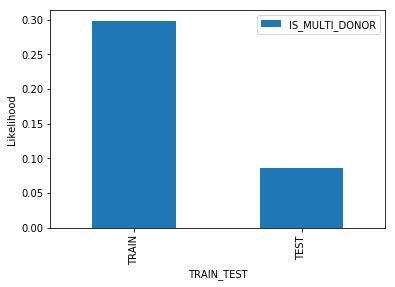

In [5]:
df = question2_prepared_data.copy()
df['TRAIN_TEST'] = ((question2_prepared_data['ISK_FD_Y_2017']==0) & 
                    (question2_prepared_data['ISK_FD_Y_2018']==0)).astype(str).replace('True','TRAIN').replace('False','TEST')
print(df['TRAIN_TEST'].value_counts())
pivot_df = df.pivot_table(index="TRAIN_TEST",values="IS_MULTI_DONOR")
pivot_df = pivot_df.reindex(['TRAIN','TEST'])
pivot_df.plot.bar()
plt.ylabel('Likelihood')
plt.show()

As expected, the percentage of multi-donors is high in training set than in test set. <br>

This is because some of the multi-donors need some time to donate again to the LUF after their first donation. <br>
This means some of the donors in the test set can still donate to LUF again in the future, but as of now they are not classified as multi-donors.

In the below cell we remove some of the features that hinder the performance of the classifier

In [6]:
relevant_cols = list(train_data.columns.values)

train_data.index = train_data['PARTNER'] #Set the index to be equal to that of PARTNER
test_data.index = test_data['PARTNER'] #Set the index to be equal to that of PARTNER

if "PARTNER" in str(relevant_cols):
    relevant_cols.remove("PARTNER")
if "ZLUF_DOCDATE" in str(relevant_cols):
    relevant_cols.remove("ZLUF_DOCDATE")
if "ZZAMNT_PAYED_NORM" in str(relevant_cols):
    relevant_cols.remove("ZZAMNT_PAYED_NORM")
#if "ZZAMNT_PAYED" in str(relevant_cols):
#    relevant_cols.remove("ZZAMNT_PAYED")

if "ISK_FD_CAT_1" in str(relevant_cols):
    relevant_cols.remove("ISK_FD_CAT_1")
if "ISK_FD_CAT_2" in str(relevant_cols):
    relevant_cols.remove("ISK_FD_CAT_2")
if "ISK_FD_CAT_3" in str(relevant_cols):
    relevant_cols.remove("ISK_FD_CAT_3")
if "ISK_FD_CAT_4" in str(relevant_cols):
    relevant_cols.remove("ISK_FD_CAT_4")
if "ISK_FD_CAT_5" in str(relevant_cols):
    relevant_cols.remove("ISK_FD_CAT_5")
if "ISK_FD_CAT_6" in str(relevant_cols):
    relevant_cols.remove("ISK_FD_CAT_6")
    
#if "ISK_FD_SHARED" in str(relevant_cols):
#    relevant_cols.remove("ISK_FD_SHARED")   

Shuffle the training & testing data

In [7]:
train_cols = relevant_cols.copy()
if "IS_MULTI_DONOR" in str(train_cols):
    train_cols.remove("IS_MULTI_DONOR")
    
train_data = train_data.sample(frac=1,random_state=1)
test_data = test_data.sample(frac=1,random_state=1)
    
train_X = train_data[train_cols].copy()
train_y = train_data["IS_MULTI_DONOR"].copy()

test_X = test_data[train_cols].copy()
test_y = test_data["IS_MULTI_DONOR"].copy()

# Random Forest

In [8]:
#Random Forest baseline
train_X_bl = train_X.copy()
test_X_bl = test_X.copy()
train_y_bl = train_y.copy()
test_y_bl = test_y.copy()

print(train_X_bl.shape)

rf = RandomForestClassifier(random_state=1)
rf.fit(train_X_bl,train_y_bl)

scores = cross_val_score(rf, train_X_bl, train_y_bl, cv=5, scoring='recall')
scores.mean()

(46206, 103)


0.3836791055360323

## Feature Selection - Random Forest

In [9]:
#Recursive Feature Elimination (RFE)
X = train_X.copy()
t_X = test_X.copy()
y = train_y.copy()
t_y = test_y.copy()

rf = RandomForestClassifier(random_state=1)
selector_rf = RFECV(rf, cv=5,scoring='recall')  #Tune via recall to get the best performance, in terms of accuracy, recall etc
selector_rf.fit(X, y)
optimized_columns_rf = X.columns[selector_rf.support_]
print(optimized_columns_rf)

Index(['ZZAMNT_PAYED', 'ISK_COMM_LET', 'ISK_FD_BANKN', 'ISK_PRO_FB',
       'NUM_D_TYL', 'REL_ORGCP', 'REL_BUR998', 'REL_Z00001'],
      dtype='object')


In [10]:
train_X_fs = train_X[optimized_columns_rf].copy()
test_X_fs = test_X[optimized_columns_rf].copy()
train_y_fs = train_y.copy()
test_y_fs = test_y.copy()

print(train_X_fs.shape)

rf_fs = RandomForestClassifier(random_state=1)
rf_fs.fit(train_X_fs,train_y_fs)

scores = cross_val_score(rf_fs, train_X_fs, train_y_fs, cv=5, scoring='recall')
scores.mean()

(46206, 8)


0.43354200482216304

## Hyper-parameter tuning - Random Forest

In [ ]:
#Hyperparameter Tuning Random forest using different scorers
train_X_fs_hpt = train_X[optimized_columns_rf].copy()
test_X_fs_hpt = test_X[optimized_columns_rf].copy()
train_y_fs_hpt = train_y.copy()
test_y_fs_hpt = test_y.copy()

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

criterion = ["entropy","gini"]
min_weight_fraction_leaf = [0.001, 0.0025, 0.005, 0.0075, 0.009, 0.01]
class_weight=['balanced','balanced_subsample',{0:.1, 1: .9},{0:.2, 1: .8},{0:.01, 1: .99},{0:.001, 1: .999},
              {0:.9, 1: .1},{0:.8, 1: .2},None]
n_estimators = [10, 25, 50, 100, 250]
max_features = ['auto', 'sqrt', 'log2', None]
bootstrap = [True, False]
random_state = [1]
n_jobs=[1]
min_samples_leaf = [0.1, 0.2, 0.3, 0.4, 0.5] #should be >0 & <= 0.5
min_samples_split = [0.1, 0.25, 0.5, 0.75, 0.9, 1.0] #should be >0 & <= 1.0
random_grid = {'criterion': criterion,
               'min_weight_fraction_leaf':min_weight_fraction_leaf,
               'class_weight':class_weight,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'bootstrap': bootstrap,
               'random_state': random_state,
               'n_jobs':n_jobs,
               'min_samples_leaf': min_samples_leaf,
               'min_samples_split': min_samples_split}
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 500, cv = 5, verbose=2, 
                               random_state=42, n_jobs = -1, scoring=scorers,refit='recall_score')
rf_random.fit(train_X_fs_hpt, train_y_fs_hpt)
rf_random.best_params_

In [ ]:
results = pd.DataFrame(rf_random.cv_results_)
results = results.sort_values(by='mean_train_accuracy_score', ascending=False)
results = results[['params','mean_test_precision_score','mean_train_precision_score','mean_test_recall_score',
         'mean_train_recall_score','mean_test_accuracy_score','mean_train_accuracy_score','mean_test_f1_score',
         'mean_train_f1_score']]
results = results[(results['mean_train_f1_score']>=0.4) & (results['mean_train_accuracy_score']>=0.6)]
results = results.sort_values(by='mean_train_recall_score', ascending=False)
results.to_csv('SQLDATA\PYTHON_OUTPUTS\RF_randomizedSearchCV_output.csv') #Save it to be used later (below cell)
rf_best_params = results['params'].iloc[0]
print(results.shape)
results.head()

In [11]:
#Get the best parameters from the saved file
rf_best_params = ast.literal_eval(pd.read_csv('SQLDATA\PYTHON_OUTPUTS\RF_randomizedSearchCV_output.csv')['params'].iloc[0])

In [12]:
train_X_fs_hpt = train_X[optimized_columns_rf].copy()
test_X_fs_hpt = test_X[optimized_columns_rf].copy()
train_y_fs_hpt = train_y.copy()
test_y_fs_hpt = test_y.copy()

print(train_X_fs_hpt.shape)
rf_fs_hpt = RandomForestClassifier(random_state=rf_best_params['random_state'], n_estimators=rf_best_params['n_estimators'],
                            min_weight_fraction_leaf=rf_best_params['min_weight_fraction_leaf'],
                            min_samples_split=rf_best_params['min_samples_split'],
                            min_samples_leaf=rf_best_params['min_samples_leaf'],max_features=rf_best_params['max_features'],
                            criterion=rf_best_params['criterion'],class_weight=rf_best_params['class_weight'],
                            bootstrap=rf_best_params['bootstrap'])
rf_fs_hpt.fit(train_X_fs_hpt,train_y_fs_hpt)

scores = cross_val_score(rf_fs_hpt, train_X_fs_hpt, train_y_fs_hpt, cv=5, scoring='recall')
scores.mean()

(46206, 8)


0.5848691502382191

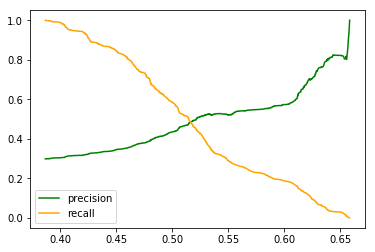

In [13]:
y_scores = cross_val_predict(rf_fs_hpt, train_X_fs_hpt, train_y_fs_hpt, cv=5,
                             method="predict_proba")
positive_y_scores = []
for score in y_scores:
    positive_y_scores.append(score[1])

precisions, recalls, thresholds = precision_recall_curve(train_y_fs_hpt, np.array(positive_y_scores))

plt.plot(thresholds,precisions[1:],color='green',label='precision')
plt.plot(thresholds,recalls[1:],color='orange',label='recall')
plt.legend()
plt.show()

Text(0.5, 0, 'Features')

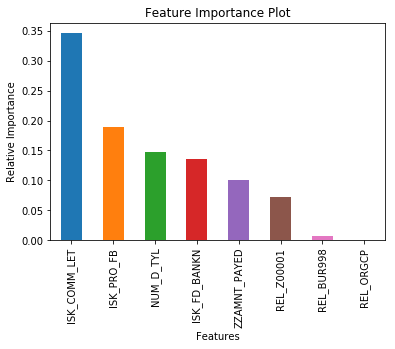

In [14]:
feat_importances = pd.Series(rf_fs_hpt.feature_importances_, index=list(optimized_columns_rf))
feat_importances.nlargest(25).plot(kind='bar')
plt.title('Feature Importance Plot')
plt.ylabel('Relative Importance')
plt.xlabel('Features')

The following features are the most important ones according to Random Forest Classifier
- <b>ISK_COMM_LET</b>: (bool) Is method of communication with the donor through LETTER
- <b>ISK_FD_BANKN</b>: (bool) Is the bank account of donor known
- <b>ISK_PRO_FB</b>: (bool) Is the donor donating from Flemish Brabant province
- <b>REL_Z00001</b>: (int) Number of alumni circles to which the donor belongs
- <b>NUM_D_TYL</b>: (int) Number of days LUF took to send the thank you letter to donors after their first donation
- <b>ZZAMNT_PAYED</b>: (int) Amount payed by the donors on their first donation
- <b>REL_BUR998</b>: (int) Number of LUF business parters with which the given donor has/had a relationships
- <b>REL_ORGCP</b>: (int) Number of organizations for which the given donor is a person of contact

Plot a correlation plot with the top 25 features with highest feature importance used by Random Forest Classifier.

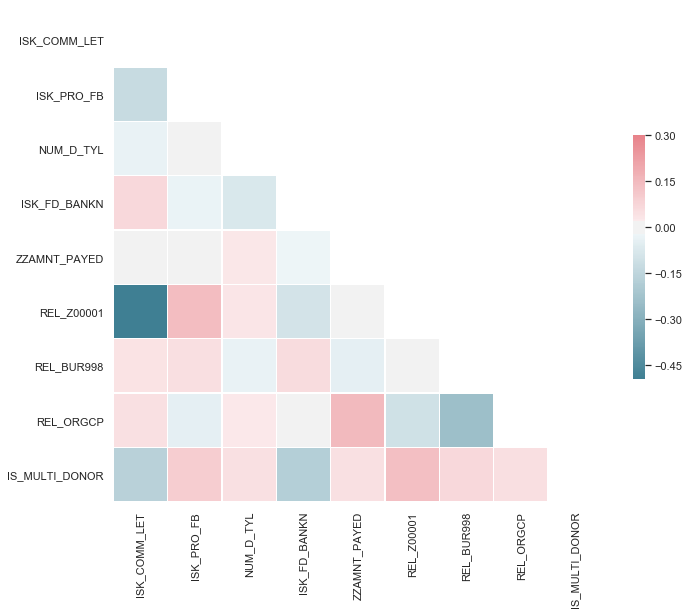

In [15]:
rg_top25_coeffs_cols = list(feat_importances.nlargest(25).index) + ['IS_MULTI_DONOR']
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

plot_correlation_heatmap(question2_prepared_data[rg_top25_coeffs_cols])

# Logistic Regression

In [16]:
#Logistic Regression Baseline
train_X_bl = train_X.copy()
test_X_bl = test_X.copy()
train_y_bl = train_y.copy()
test_y_bl = test_y.copy()

print(train_X_bl.shape)

lr = LogisticRegression()
lr.fit(train_X_bl,train_y_bl)

scores = cross_val_score(lr, train_X_bl, train_y_bl, cv=5, scoring='recall')
scores.mean()

(46206, 103)


0.2914913773631488

## Feature Selection - Logistic Regression

In [17]:
#Recursive Feature Elimination (RFE)
X = train_X.copy()
t_X = test_X.copy()
y = train_y.copy()
t_y = test_y.copy()

lr = LogisticRegression()
selector_lr = RFECV(lr, cv=5,scoring='recall')
selector_lr.fit(X, y)
optimized_columns_lr = X.columns[selector_lr.support_]
print(optimized_columns_lr)

Index(['XSEXF', 'XSEXM', 'ISK_PERSON', 'ISK_BIRTHPL', 'ISK_BU_LANGU',
       'ISK_CNT_ORIGIN', 'ISK_NATIONALITY', 'ISK_VOORNAAM', 'ISK_LANGU_CORR',
       'ISK_MARST',
       ...
       'ZLUF_KERKELIJK', 'ZLUF_LIJST', 'ZLUF_ORG_ALS_PERSOON',
       'ZLUF_ORG_VERENIGING', 'ZLUF_SCHENKINTERESSE_ARTnCULTURE',
       'ZLUF_SCHENKINTERESSE_CHILDREN', 'ZLUF_SCHENKINTERESSE_DEVCOOP',
       'ZLUF_SCHENKINTERESSE_HEALTHCARE', 'ZLUF_SCHENKINTERESSE_HERITAGE',
       'ZLUF_SCHENKINTERESSE_SCHOLARSHIPS'],
      dtype='object', length=101)


In [18]:
#Logistic Regression + Feature Selection
train_X_fs = train_X[optimized_columns_lr].copy()
test_X_fs = test_X[optimized_columns_lr].copy()
train_y_fs = train_y.copy()
test_y_fs = test_y.copy()

print(train_X_fs.shape)

lr_fs = LogisticRegression()
lr_fs.fit(train_X_fs,train_y_fs)

scores = cross_val_score(lr_fs, train_X_bl, train_y_bl, cv=5, scoring='recall')
scores.mean()

(46206, 101)


0.2914913773631488

## Hyper-parameter tuning - Logistic Regression

In [ ]:
#Hyper-parameter tuning for Logistic Regression using RamdomizedSearchCV
train_X_fs_hpt = train_X[optimized_columns_lr].copy()
test_X_fs_hpt = test_X[optimized_columns_lr].copy()
train_y_fs_hpt = train_y.copy()
test_y_fs_hpt = test_y.copy()

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}
tol=[0.0001,0.001,0.005,0.01,0.05,0.1]
c = [1.0,2.0,5.0]
fit_intercept = [True,False]
intercept_scaling = [1,2,5,10]
class_weight = ['balanced',None]
solver = ['newton-cg', 'lbfgs', 'liblinear']
max_iter = [20,50,100,200]
random_grid = {'tol': tol,
               'C': c,
               'fit_intercept': fit_intercept,
               'intercept_scaling': intercept_scaling,
               'class_weight': class_weight,
               'solver': solver,
               'max_iter': max_iter}
lr = LogisticRegression()
lr_random = RandomizedSearchCV(estimator = lr, param_distributions = random_grid, n_iter = 500, cv = 5, verbose=2, 
                               random_state=42, n_jobs = -1,scoring=scorers,refit='recall_score')
lr_random.fit(train_X_fs_hpt, train_y_fs_hpt)
lr_random.best_params_

In [ ]:
results = pd.DataFrame(lr_random.cv_results_)
results = results.sort_values(by='mean_train_accuracy_score', ascending=False)
results = results[['params','mean_test_precision_score','mean_train_precision_score','mean_test_recall_score',
         'mean_train_recall_score','mean_test_accuracy_score','mean_train_accuracy_score','mean_test_f1_score',
         'mean_train_f1_score']]
results.to_csv('SQLDATA\PYTHON_OUTPUTS\LR_randomizedSearchCV_output.csv')
results = results[(results['mean_train_f1_score']>=0.4) & (results['mean_train_accuracy_score']>=0.6)]
results = results.sort_values(by='mean_train_recall_score', ascending=False)
results.to_csv('SQLDATA\PYTHON_OUTPUTS\LR_randomizedSearchCV_output.csv')  #Save it to be used later (below cell)
lr_best_params = results['params'].iloc[0]
print(results.shape)
results.head()

In [19]:
#Get the best parameters from the saved file
lr_best_params = ast.literal_eval(pd.read_csv('SQLDATA\PYTHON_OUTPUTS\LR_randomizedSearchCV_output.csv')['params'].iloc[0])

In [20]:
#Logistic Regression + Feature Selection + Hyperparameter Tuning
train_X_fs_hpt = train_X[optimized_columns_lr].copy()
test_X_fs_hpt = test_X[optimized_columns_lr].copy()
train_y_fs_hpt = train_y.copy()
test_y_fs_hpt = test_y.copy()


print(train_X_fs_hpt.shape)


lr_fs_hpt = LogisticRegression(tol=lr_best_params['tol'],solver=lr_best_params['solver'],max_iter=lr_best_params['max_iter'],
                               intercept_scaling=lr_best_params['intercept_scaling'],
                               fit_intercept=lr_best_params['fit_intercept'],
                               class_weight=lr_best_params['class_weight'],C=lr_best_params['C'])
lr_fs_hpt.fit(train_X_fs_hpt,train_y_fs_hpt)

scores = cross_val_score(lr_fs_hpt, train_X_fs_hpt, train_y_fs_hpt, cv=5, scoring='recall')
scores.mean()

(46206, 101)


0.5990006356010106

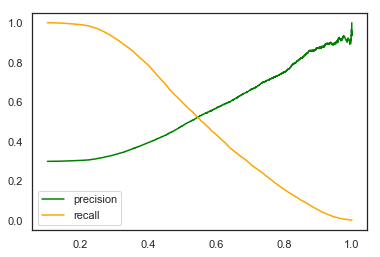

In [21]:
y_scores = cross_val_predict(lr_fs_hpt, train_X_fs_hpt, train_y_fs_hpt, cv=5,
                             method="predict_proba")
positive_y_scores = []
for score in y_scores:
    positive_y_scores.append(score[1])

precisions, recalls, thresholds = precision_recall_curve(train_y_fs_hpt, np.array(positive_y_scores))

plt.plot(thresholds,precisions[1:],color='green',label='precision')
plt.plot(thresholds,recalls[1:],color='orange',label='recall')
plt.legend()
plt.show()

In [22]:
lr_coef = lr_fs_hpt.coef_
lr_coef = [np.abs(item) for sublist in lr_coef for item in sublist]
coef_weights = pd.DataFrame({"Cols":list(optimized_columns_lr),"Coef":lr_coef})
coef_weights = coef_weights.sort_values("Coef",ascending=False)
coef_weights.reset_index(drop=True,inplace=True)
coef_weights.head(10)

,Cols,Coef
0,ISK_COMM_LET,0.834516
1,REL_ORGCP,0.750796
2,ISK_VOORNAAM,0.736406
3,REL_BUR998,0.705129
4,ISK_FD_VGS,0.552933
5,ISK_FD_M_12,0.481146
6,ISK_FD_TAX_NE,0.456193
7,REL_BUR021,0.415371
8,ISK_FD_M_1,0.377594
9,ISK_FD_M_8,0.349475


Plot a correlation plot with the top 25 features with highest absolute weight coefficients from Logitstic Regression Classifier.

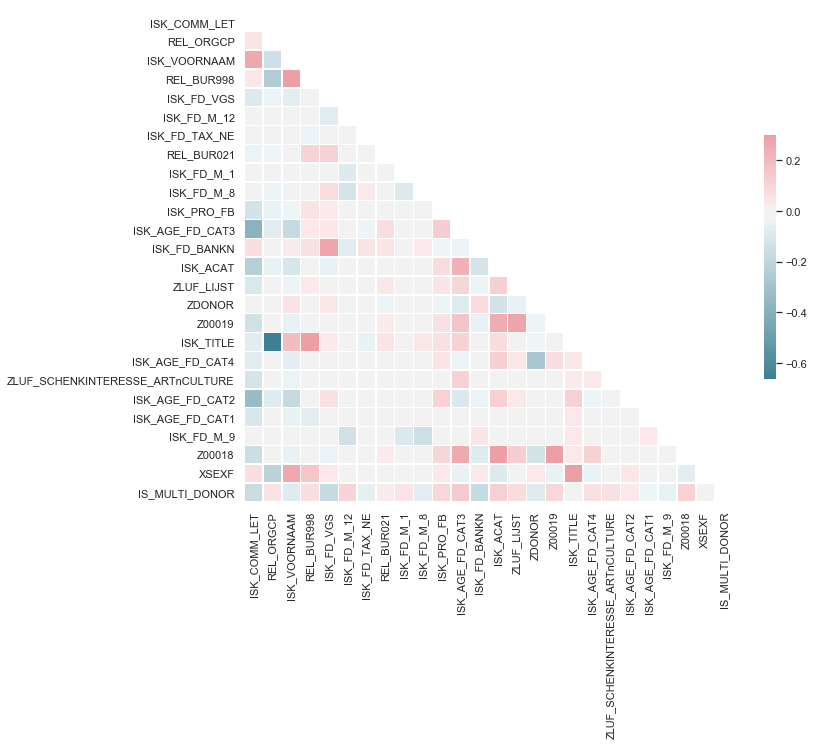

In [23]:
lr_top25_coeffs_cols = list(coef_weights['Cols'][:25]) + ['IS_MULTI_DONOR']

def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

plot_correlation_heatmap(question2_prepared_data[lr_top25_coeffs_cols])

## Apply PCA & Classify using SVM

In [24]:
#Apply PCA  (n_components = 30)
train_X_copy = train_X.copy()
test_X_copy = test_X.copy()
train_y_copy = train_y.copy()
test_y_copy = test_y.copy()

print(train_X_copy.shape)

n_components = 30      #30 seems optimal. 20 is good as well 
# Standardizing the features
#train_X = StandardScaler().fit_transform(train_X_copy)
#test_X = StandardScaler().fit_transform(test_X_copy)
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(train_X_copy)

X_train_pca = pca.transform(train_X_copy)
X_test_pca = pca.transform(test_X_copy)
print(X_train_pca.shape)


#SVM
svm = SVC(kernel='rbf', class_weight='balanced')
svm.fit(X_train_pca, train_y_copy)

scores = cross_val_score(svm, X_train_pca, train_y_copy, cv=5, scoring='recall')
scores.mean()

(46206, 103)
(46206, 30)


0.5845059121399793

#### Predicting donors who started donating to LUF after 2017 and who is more likely to become multi-donors

In [25]:
#Random Forest
train_X_fs_hpt = train_X[optimized_columns_rf].copy()
test_X_fs_hpt = test_X[optimized_columns_rf].copy()
train_y_fs_hpt = train_y.copy()
test_y_fs_hpt = test_y.copy()

rf_fs_hpt = RandomForestClassifier(random_state=rf_best_params['random_state'], n_estimators=rf_best_params['n_estimators'],
                            min_weight_fraction_leaf=rf_best_params['min_weight_fraction_leaf'],
                            min_samples_split=rf_best_params['min_samples_split'],
                            min_samples_leaf=rf_best_params['min_samples_leaf'],max_features=rf_best_params['max_features'],
                            criterion=rf_best_params['criterion'],class_weight=rf_best_params['class_weight'],
                            bootstrap=rf_best_params['bootstrap'])
rf_fs_hpt.fit(train_X_fs_hpt,train_y_fs_hpt)

rf_predictions = rf_fs_hpt.predict(test_X_fs_hpt)

df = pd.DataFrame({"a":test_y_fs_hpt,"b":rf_predictions})
TP = ((df['a']==df['b']) & (df['a'] == 1)).astype(int).sum(); print('TP = ' + str(TP))
FP = ((df['a']!=df['b']) & (df['a'] == 0)).astype(int).sum(); print('FP = ' + str(FP))
FN = ((df['a']!=df['b']) & (df['a'] == 1)).astype(int).sum(); print('FN = ' + str(FN))
TN = ((df['a']==df['b']) & (df['a'] == 0)).astype(int).sum(); print('TN = ' + str(TN))
Accuracy = (TP+TN)/(TP+TN+FP+FN);print('Accuracy = ' + str(Accuracy))
Precision = TP/(TP+FP); print('Precision = ' + str(Precision))
Recall = TP/(TP+FN); print('Recall = ' + str(Recall))
F1 = 2 * (Precision * Recall) / (Precision + Recall); print('F1 = ' + str(F1))

print('\nNumber of predicted multi-donors by Random Forest: ' + str(sum(rf_predictions)))

rf_predictions_df = pd.DataFrame(index=test_X_fs_hpt.index)
rf_predictions_df['RF_MultiDonors_Predictions'] = rf_predictions
rf_predictions_df.to_csv('SQLDATA\PYTHON_OUTPUTS\RF_multi_donors_predictions.csv')
rf_predictions_df.tail()

TP = 379
FP = 3200
FN = 550
TN = 6562
Accuracy = 0.6492376765503695
Precision = 0.10589550153674211
Recall = 0.40796555435952636
F1 = 0.16814551907719608

Number of predicted multi-donors by Random Forest: 3579


,RF_MultiDonors_Predictions
PARTNER,
201193106,0
201283448,0
200227665,1
201210033,0
200032754,1


In [26]:
#Logistic Regression
train_X_fs_hpt = train_X[optimized_columns_lr].copy()
test_X_fs_hpt = test_X[optimized_columns_lr].copy()
train_y_fs_hpt = train_y.copy()
test_y_fs_hpt = test_y.copy()

lr_fs_hpt = LogisticRegression(tol=lr_best_params['tol'],solver=lr_best_params['solver'],max_iter=lr_best_params['max_iter'],
                               intercept_scaling=lr_best_params['intercept_scaling'],
                               fit_intercept=lr_best_params['fit_intercept'],
                               class_weight=lr_best_params['class_weight'],C=lr_best_params['C'])
lr_fs_hpt.fit(train_X_fs_hpt,train_y_fs_hpt)

lr_predictions = lr_fs_hpt.predict(test_X_fs_hpt)

df = pd.DataFrame({"a":test_y,"b":lr_predictions})
TP = ((df['a']==df['b']) & (df['a'] == 1)).astype(int).sum(); print('TP = ' + str(TP))
FP = ((df['a']!=df['b']) & (df['a'] == 0)).astype(int).sum(); print('FP = ' + str(FP))
FN = ((df['a']!=df['b']) & (df['a'] == 1)).astype(int).sum(); print('FN = ' + str(FN))
TN = ((df['a']==df['b']) & (df['a'] == 0)).astype(int).sum(); print('TN = ' + str(TN))
Accuracy = (TP+TN)/(TP+TN+FP+FN);print('Accuracy = ' + str(Accuracy))
Precision = TP/(TP+FP); print('Precision = ' + str(Precision))
Recall = TP/(TP+FN); print('Recall = ' + str(Recall))
F1 = 2 * (Precision * Recall) / (Precision + Recall); print('F1 = ' + str(F1))

print('\nNumber of predicted multi-donors by Logistic Regression: ' + str(sum(lr_predictions)))

lr_predictions_df = pd.DataFrame(index=test_X_fs_hpt.index)
lr_predictions_df['LR_MultiDonors_Predictions'] = lr_predictions
lr_predictions_df.to_csv('SQLDATA\PYTHON_OUTPUTS\LR_multi_donors_predictions.csv')
lr_predictions_df.tail()

TP = 282
FP = 2020
FN = 647
TN = 7742
Accuracy = 0.7505378355626228
Precision = 0.12250217202432667
Recall = 0.30355220667384286
F1 = 0.1745589600742804

Number of predicted multi-donors by Logistic Regression: 2302


,LR_MultiDonors_Predictions
PARTNER,
201193106,0
201283448,0
200227665,0
201210033,0
200032754,0


In [27]:
#SVM
train_X_copy = train_X.copy()
test_X_copy = test_X.copy()
train_y_copy = train_y.copy()
test_y_copy = test_y.copy()

n_components = 30      #30 seems optimal. 20 is good as well 
# Standardizing the features
#train_X = StandardScaler().fit_transform(train_X_copy)
#test_X = StandardScaler().fit_transform(test_X_copy)
pca = PCA(n_components=n_components, svd_solver='randomized',whiten=True).fit(train_X_copy)

X_train_pca = pca.transform(train_X_copy)
X_test_pca = pca.transform(test_X_copy)

svm = SVC(kernel='rbf', class_weight='balanced')
svm.fit(X_train_pca, train_y_copy)

svm_predictions = svm.predict(X_test_pca)

df = pd.DataFrame({"a":test_y_copy,"b":svm_predictions})
TP = ((df['a']==df['b']) & (df['a'] == 1)).astype(int).sum(); print('TP = ' + str(TP))
FP = ((df['a']!=df['b']) & (df['a'] == 0)).astype(int).sum(); print('FP = ' + str(FP))
FN = ((df['a']!=df['b']) & (df['a'] == 1)).astype(int).sum(); print('FN = ' + str(FN))
TN = ((df['a']==df['b']) & (df['a'] == 0)).astype(int).sum(); print('TN = ' + str(TN))
Accuracy = (TP+TN)/(TP+TN+FP+FN);print('Accuracy = ' + str(Accuracy))
Precision = TP/(TP+FP); print('Precision = ' + str(Precision))
Recall = TP/(TP+FN); print('Recall = ' + str(Recall))
F1 = 2 * (Precision * Recall) / (Precision + Recall); print('F1 = ' + str(F1))

print('\nNumber of predicted multi-donors by SVM: ' + str(sum(svm_predictions)))

svm_predictions_df = pd.DataFrame(index=test_X_fs_hpt.index)
svm_predictions_df['SVM_MultiDonors_Predictions'] = svm_predictions
svm_predictions_df.to_csv('SQLDATA\PYTHON_OUTPUTS\SVM_multi_donors_predictions.csv')
svm_predictions_df.tail()

TP = 254
FP = 1533
FN = 675
TN = 8229
Accuracy = 0.7934711439528576
Precision = 0.1421376608841634
Recall = 0.27341227125941875
F1 = 0.18703976435935202

Number of predicted multi-donors by SVM: 1787


,SVM_MultiDonors_Predictions
PARTNER,
201193106,0
201283448,0
200227665,0
201210033,0
200032754,1


#### Merge all predictions

In [28]:
multi_donor_predictions_df = pd.concat([rf_predictions_df,lr_predictions_df,svm_predictions_df],axis=1)
print(multi_donor_predictions_df.shape)
multi_donor_predictions_df.to_csv('SQLDATA\PYTHON_OUTPUTS\multi_donors_predictions.csv')
multi_donor_predictions_df.head(10)

(10691, 3)


,RF_MultiDonors_Predictions,LR_MultiDonors_Predictions,SVM_MultiDonors_Predictions
PARTNER,,,
201219741,0,0,0
201279590,0,1,1
201275190,0,0,0
201295002,0,0,0
201296886,0,0,0
201308334,0,0,0
200354189,1,0,1
200154388,1,1,1
200320149,1,1,0


In [29]:
multi_donor_predictions_df['Agg_Model_Predictions'] = (multi_donor_predictions_df['RF_MultiDonors_Predictions'] + 
                                                       multi_donor_predictions_df['LR_MultiDonors_Predictions'] + 
                                                       multi_donor_predictions_df['SVM_MultiDonors_Predictions'])
multi_donor_predictions_df['Agg_Model_Predictions'] = multi_donor_predictions_df['Agg_Model_Predictions'].replace(2,1).replace(3,1)
actual_2018 = pd.DataFrame({"Actual_2018":test_y_copy})
df = pd.concat([actual_2018,multi_donor_predictions_df[['Agg_Model_Predictions']]],axis=1)
df = df.rename(columns={'Actual_2018':'a','Agg_Model_Predictions':'b'})
TP = ((df['a']==df['b']) & (df['a'] == 1)).astype(int).sum(); print('TP = ' + str(TP))
FP = ((df['a']!=df['b']) & (df['a'] == 0)).astype(int).sum(); print('FP = ' + str(FP))
FN = ((df['a']!=df['b']) & (df['a'] == 1)).astype(int).sum(); print('FN = ' + str(FN))
TN = ((df['a']==df['b']) & (df['a'] == 0)).astype(int).sum(); print('TN = ' + str(TN))
Accuracy = (TP+TN)/(TP+TN+FP+FN);print('Accuracy = ' + str(Accuracy))
Precision = TP/(TP+FP); print('Precision = ' + str(Precision))
Recall = TP/(TP+FN); print('Recall = ' + str(Recall))
F1 = 2 * (Precision * Recall) / (Precision + Recall); print('F1 = ' + str(F1))

print('\nNumber of predicted multi-donors by all models: ' + str(sum(df['b'])))

TP = 481
FP = 4087
FN = 448
TN = 5675
Accuracy = 0.5758114301749134
Precision = 0.10529772329246935
Recall = 0.5177610333692142
F1 = 0.1750045479352374

Number of predicted multi-donors by all models: 4568
